In [0]:
from __future__ import print_function

In [0]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

%pylab inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [0]:
def plot_stick(y):
    for half_w in [y[3]*256/2*i for i in [1,-1]]:
        plt.plot([y[2]*256, y[0]*256]+half_w,
                 [256, y[1]*256], 
                 c='yellow', 
                 linewidth=3);

## Import data

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving w18.npy to w18.npy
Saving w19.npy to w19.npy
Saving w20.npy to w20.npy
Saving w21.npy to w21.npy
User uploaded file "w18.npy" with length 128 bytes
User uploaded file "w19.npy" with length 128 bytes
User uploaded file "w20.npy" with length 128 bytes
User uploaded file "w21.npy" with length 791117 bytes


## Start

In [0]:
# Read images and targets
test_size = 10
n_img = 425
trg = pd.read_csv('trg.csv', usecols=['Xo', 'Yo', 'X1', 'W'], nrows=n_img)
x = np.zeros((n_img, 256, 256, 3))
for i in range(n_img):
    x[i,:,:,:] = np.array(Image.open('img_'+str(i+1)+'.jpg'))/255
    
# Split data to train (80%), validation (20%-4 images) and test (4 images) sets
i_train, i_test  = train_test_split(list(range(n_img)), test_size=0.2, random_state=0)
xTrain = x[i_train]
yTrain = trg.values[i_train]
xValid = x[i_test[:-test_size]]
yValid = trg.values[i_test[:-test_size]]
xTest = x[i_test[-test_size:]]
yTest = trg.values[i_test[-test_size:]]
print(xTrain.shape, yTrain.shape)
print(xValid.shape, yValid.shape)
print(xTest.shape, yTest.shape)

(340, 256, 256, 3) (340, 4)
(75, 256, 256, 3) (75, 4)
(10, 256, 256, 3) (10, 4)


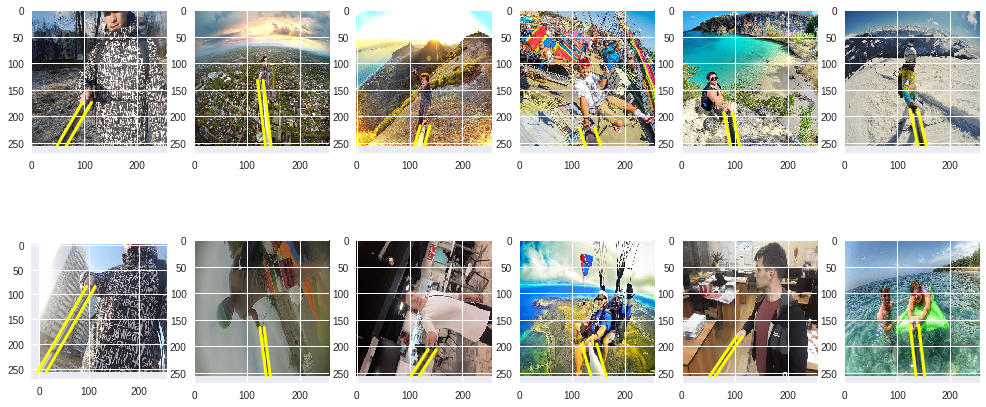

In [0]:
# Check train images 
plt.subplots(figsize=(17,12))
nStart = 66
for n_img in range(nStart, nStart+12):
    plt.subplot(3,6,n_img-nStart+1)
    pylab.imshow(xTrain[n_img]);
    plot_stick(yTrain[n_img])

In [0]:
# Add mirrored copies
xTrain = np.vstack([xTrain, np.flip(xTrain, 2)])
yTrain = np.vstack([yTrain, np.hstack([1-yTrain[:,:1], 
                                       yTrain[:,1:2],
                                       1-yTrain[:,2:3],
                                       yTrain[:,3:4]])])

xValid = np.vstack([xValid, np.flip(xValid, 2)])
yValid = np.vstack([yValid, np.hstack([1-yValid[:,:1], 
                                       yValid[:,1:2],
                                       1-yValid[:,2:3],
                                       yValid[:,3:4]])])
xTest = np.vstack([xTest, np.flip(xTest, 2)])
yTest = np.vstack([yTest, np.hstack([1-yTest[:,:1], 
                                       yTest[:,1:2],
                                       1-yTest[:,2:3],
                                       yTest[:,3:4]])])
print(xTrain.shape, yTrain.shape)
print(xValid.shape, yValid.shape)
print(xTest.shape, yTest.shape)

(680, 256, 256, 3) (680, 4)
(150, 256, 256, 3) (150, 4)
(20, 256, 256, 3) (20, 4)


In [0]:
# Add copies with various brightness
xTrain = np.vstack([xTrain, xTrain**0.5, xTrain**2])
xValid = np.vstack([xValid, xValid**0.5, xValid**2])
xTest = np.vstack([xTest, xTest**0.5, xTest**2])
yTrain = np.vstack(3*[yTrain])
yValid = np.vstack(3*[yValid])
yTest = np.vstack(3*[yTest])
print(xTrain.shape, yTrain.shape)
print(xValid.shape, yValid.shape)
print(xTest.shape, yTest.shape)

(2040, 256, 256, 3) (2040, 4)
(450, 256, 256, 3) (450, 4)
(60, 256, 256, 3) (60, 4)


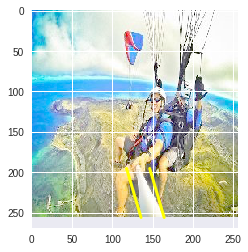

In [0]:
# Final test
n_img = 755
pylab.imshow(xTrain[n_img])
plot_stick(yTrain[n_img])

In [0]:
from keras import regularizers, optimizers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Input, Dropout, Activation, MaxPool2D, AvgPool2D, Flatten, Dense, BatchNormalization
from keras import applications
import h5py
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

img_width, img_height = 256, 256
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
#model = load_model("model_vgg16.h5")

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
for layer in model.layers[:-4]:
    layer.trainable = False

In [0]:
#Adding custom Layers 
x = model.get_layer(index=-1).output
x = Flatten()(x)
x = Dropout(rate=0.5)(x)
reg_L2 = regularizers.l2(0.1)
predictions = Dense(4, activation="sigmoid", kernel_regularizer=reg_L2)(x)

# creating the final model 
my_model = Model(inputs = model.input, outputs = predictions)

In [0]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [0]:
for i in range(18, 22):
    l = my_model.layers[i]
    l.set_weights(np.load('w'+str(i)+'.npy'))

In [0]:
opt = optimizers.Adam(lr=0.0001)
my_model.compile(optimizer = opt , loss = 'mean_absolute_error', metrics=[])

In [0]:
wfile = 'weights.hdf5'
checkpoint = ModelCheckpoint(wfile, save_best_only=True, verbose=1)
histoty = my_model.fit(xTrain, yTrain, 
                       epochs=30,
                       #validation_data=(xValid, yValid), 
                       validation_split = 0.2,
                       callbacks=[checkpoint], 
                       batch_size=64, 
                       shuffle=True,
                       initial_epoch=0)

Train on 1632 samples, validate on 408 samples
Epoch 1/30
1632/1632 [==============================] - 27s 16ms/step - loss: 0.0358 - val_loss: 0.0207

Epoch 00001: val_loss improved from inf to 0.02066, saving model to weights.hdf5
Epoch 2/30
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0285 - val_loss: 0.0226

Epoch 00002: val_loss did not improve from 0.02066
Epoch 3/30
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0285 - val_loss: 0.0227

Epoch 00003: val_loss did not improve from 0.02066
Epoch 4/30
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0292 - val_loss: 0.0237

Epoch 00004: val_loss did not improve from 0.02066
Epoch 5/30
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0289 - val_loss: 0.0214

Epoch 00005: val_loss did not improve from 0.02066
Epoch 6/30
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0287 - val_loss: 0.0253

Epoch 00006: val_loss did not improve 

KeyboardInterrupt: ignored

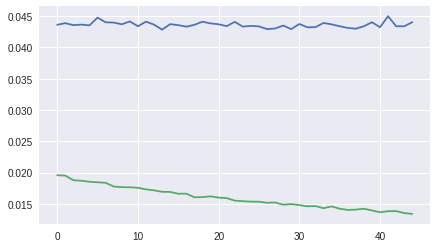

In [0]:
plt.plot(histoty.history['val_loss'][5:]);
plt.plot(histoty.history['loss'][5:]);

In [0]:
my_model.load_weights(wfile)
my_model.compile(optimizer = 'Adam' , loss = 'mean_absolute_error')

yPred = my_model.predict(xValid)
print('Validation: ', (np.abs(yPred-yValid).mean(axis=0)), "mean: ", (np.abs(yPred-yValid)).mean())

yPred = my_model.predict(xTest)
print('Test      : ', (np.abs(yPred-yTest)).mean(axis=0), "mean: ", (np.abs(yPred-yTest)).mean())

Validation:  [0.04442959 0.06709673 0.06821384 0.02756764] mean:  0.05182695189317068
Test      :  [0.02110609 0.10024548 0.04871123 0.02170421] mean:  0.04794175394972166


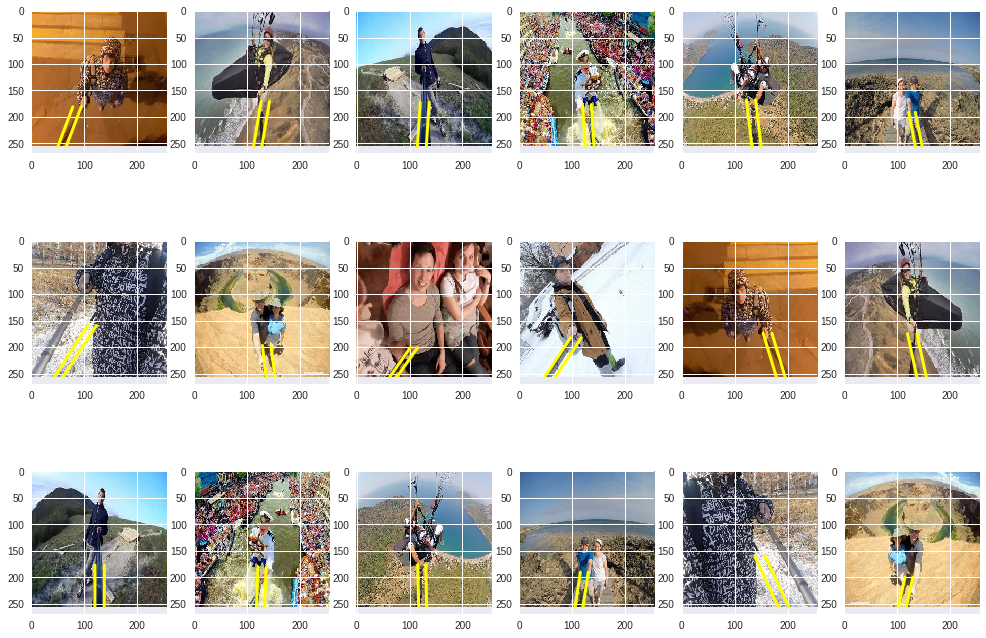

In [0]:
imgWidth = 256
imgHeight = 256
plt.subplots(figsize=(17,12))
nStart = 0
for n_img in range(nStart, nStart+18):
    plt.subplot(3,6,n_img-nStart+1)
    pylab.imshow(xTest[n_img].reshape(imgHeight, imgWidth,3));
    plot_stick(yPred[n_img])

In [0]:
my_model.save("model.h5")
from google.colab import files
files.download('model.h5')

In [0]:
my_model.save_weights('w.hdf5')